In [29]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import numpy as np
import time

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [22]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_data(sqlContext, filepath):
    df = sqlContext.read.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .option("inferSchema", "true") \
        .option("nullValue", "-")\
        .load(filepath)

    return df

def read_buste_data_v3(filepath, sqlContext):
    data_frame = sqlContext.read.csv(filepath, header=False,
                                     inferSchema=True,nullValue="-")
    while len(data_frame.columns) < 16:
        col_name = "_c" + str(len(data_frame.columns))
        data_frame = data_frame.withColumn(col_name, F.lit(None))

    data_frame = rename_columns(
        data_frame,
        [
            ("_c0", "route"),
            ("_c1", "tripNum"),
            ("_c2", "shapeId"),
            ("_c3", "shapeSequence"),
            ("_c4", "shapeLat"),
            ("_c5", "shapeLon"),
            ("_c6", "distanceTraveledShape"),
            ("_c7", "busCode"),
            ("_c8", "gpsPointId"),
            ("_c9", "gpsLat"),
            ("_c10", "gpsLon"),
            ("_c11", "distanceToShapePoint"),
            ("_c12", "timestamp"),
            ("_c13", "busStopId"),
            ("_c14", "problem"),
            ("_c15", "userBirthdate"),
            ("_c16", "cardTimestamp"),
            ("_c17", "lineName"),
            ("_c18", "cardNum"),
            ("_c19", "userGender"),
        ]
    )

    date = "-".join(filepath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.date_sub(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def read_buste_data_old(filepath, sqlContext):
    data_frame = sqlContext.read.csv(filepath, header=False,
                                     inferSchema=True,nullValue="-")
    while len(data_frame.columns) < 16:
        col_name = "_c" + str(len(data_frame.columns))
        data_frame = data_frame.withColumn(col_name, F.lit(None))

    data_frame = rename_columns(
        data_frame,
        [
            ("_c0", "route"),
            ("_c1", "tripNum"),
            ("_c2", "shapeId"),
            ("_c3", "shapeSequence"),
            ("_c4", "shapeLat"),
            ("_c5", "shapeLon"),
            ("_c6", "distanceTraveledShape"),
            ("_c7", "busCode"),
            ("_c8", "gpsPointId"),
            ("_c9", "gpsLat"),
            ("_c10", "gpsLon"),
            ("_c11", "distanceToShapePoint"),
            ("_c12", "timestamp"),
            ("_c13", "busStopId"),
            ("_c14", "problem"),
            ("_c15", "numPassengers")
        ]
    )

    date = "-".join(filepath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.from_unixtime(
        F.unix_timestamp(F.date_sub(F.col("date"),1),'yyyy-MM-dd'),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

### Read Pre-OD Data

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext(sc)

In [4]:
exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/'
pre_od_data = read_data(sqlContext,exp_data_folder_path + 'pre_od_matrix') \
                .withColumn('o_date',F.from_unixtime(F.unix_timestamp(F.col('o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .withColumn('next_o_date',F.from_unixtime(F.unix_timestamp(F.col('next_o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .orderBy(['cardNum','o_date','o_timestamp'])

In [5]:
printdf(pre_od_data)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,175,BC289,2017-05-10,10,17:02:45,1743,5444509,-25.451133,-49.252930,31749,...,17:46:02,2789,5510463,-25.432528,-49.272411,26355,1,72165,74762,43.283333
1,370,BC032,2017-05-10,9,17:46:02,2789,5510463,-25.432528,-49.272411,26355,...,17:02:45,1743,5444509,-25.451133,-49.252930,31749,0,74762,72165,-1.000000
2,372,BC312,2017-05-10,2,06:55:21,1891,6136884,-25.427901,-49.263238,29914,...,17:09:27,1719,5305706,-25.452114,-49.223827,14404,3,35721,72567,614.100000
3,50,LB602,2017-05-10,6,17:09:27,1719,5305706,-25.452114,-49.223827,14404,...,06:55:21,1891,6136884,-25.427901,-49.263238,29914,2,72567,35721,-1.000000
4,542,GA124,2017-05-10,6,07:01:40,1988,6403964,-25.550431,-49.265282,31256,...,17:05:57,1785,5950930,-25.466362,-49.279723,29165,5,36100,72357,604.283333
5,216,CA600,2017-05-10,7,17:05:57,1785,5950930,-25.466362,-49.279723,29165,...,07:01:40,1988,6403964,-25.550431,-49.265282,31256,4,72357,36100,-1.000000
6,533,EA166,2017-05-10,3,07:50:18,2872,6247890,-25.516804,-49.230914,30037,...,16:47:25,3260,6011921,-25.447553,-49.225671,32704,7,39018,71245,537.116667
7,20,KB605,2017-05-10,6,16:47:25,3260,6011921,-25.447553,-49.225671,32704,...,07:50:18,2872,6247890,-25.516804,-49.230914,30037,6,71245,39018,-1.000000
8,779,JC865,2017-05-10,1,05:55:17,2904,5602222,-25.459817,-49.319788,33567,...,15:02:51,2194,4299859,-25.435150,-49.273297,26149,9,32117,64971,547.566667
9,777,JC008,2017-05-10,8,15:02:51,2194,4299859,-25.435150,-49.273297,26149,...,05:55:17,2904,5602222,-25.459817,-49.319788,33567,8,64971,32117,-1.000000


In [6]:
#pre_od_data.columns

### Reading Bus Trip Data

In [7]:
old_exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v2/buste-output/'
bus_trip_data = read_buste_data_old(old_exp_data_folder_path + '/2017_05_11_veiculos.csv/part-00000', sqlContext)

In [8]:
bus_trip_data = bus_trip_data.withColumn("gps_timestamp", F.concat(F.col("date"), F.lit(" "), F.col("timestamp")))
bus_trip_data = bus_trip_data.withColumn("gps_timestamp_in_secs", F.unix_timestamp(F.col("gps_timestamp"), "yyyy-MM-dd HH:mm:ss"))

In [9]:
bus_trip_data = bus_trip_data.na.drop(subset=["route","busCode","busStopId","gps_timestamp_in_secs","tripNum"]) \
                            .dropDuplicates(['route','busCode','tripNum','busStopId']) \
                            .orderBy(['route','busCode','tripNum','gps_timestamp_in_secs']) \
                            .withColumn('id',F.monotonically_increasing_id()) \
                            .withColumn('route', F.col('route').cast(T.IntegerType()))

### Trying a different approach

In [10]:
pre_od_data.printSchema()

root
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: string (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: integer (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: string (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_i

In [11]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- busStopId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- numPassengers: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- gps_timestamp: string (nullable = true)
 |-- gps_timestamp_in_secs: long (nullable = true)
 |-- id: long (nullable = false)



In [12]:
#sample_size = 10
#pre_od_data_sample = pre_od_data.limit(sample_size)
pre_od_data_sample = pre_od_data

In [13]:
cond = [bus_trip_data.route == pre_od_data_sample.o_route, 
        bus_trip_data.busCode == pre_od_data_sample.o_bus_code, 
        bus_trip_data.date == pre_od_data_sample.o_date,
        bus_trip_data.tripNum == pre_od_data_sample.o_tripNum]
#od_trips = bus_trip_data.join(pre_od_data_sample, (((bus_trip_data.route == pre_od_data_sample.o_route) & (bus_trip_data.busCode == pre_od_data_sample.o_bus_code)) & ((bus_trip_data.date == pre_od_data_sample.o_date) & (bus_trip_data.tripNum == pre_od_data_sample.o_tripNum))), 'inner')
od_trips = bus_trip_data.join(pre_od_data_sample, cond, 'left_outer')

In [14]:
printdf(od_trips.orderBy(['route','busCode','tripNum','gps_timestamp_in_secs']))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,NaN,1,2934,6446501,-25.452183,-49.224040,0.000,DC852,None,-25.452220,...,None,None,None,None,None,None,None,None,None,None
1,NaN,1,2934,6447496,-25.450932,-49.219970,432.312,DC852,None,-25.450976,...,None,None,None,None,None,None,None,None,None,None
2,NaN,1,2934,6447510,-25.448710,-49.220020,739.771,DC852,None,-25.448616,...,None,None,None,None,None,None,None,None,None,None
3,NaN,1,2934,6447525,-25.446724,-49.221252,1001.839,DC852,None,-25.446655,...,None,None,None,None,None,None,None,None,None,None
4,NaN,1,2934,6447538,-25.444639,-49.223163,1393.901,DC852,None,-25.444756,...,None,None,None,None,None,None,None,None,None,None
5,NaN,1,2934,6447574,-25.440200,-49.221386,2247.402,DC852,None,-25.440206,...,None,None,None,None,None,None,None,None,None,None
6,1.0,1,2938,6451385,-25.428133,-49.264531,338.081,BN997,None,-25.428198,...,None,None,None,None,None,None,None,None,None,None
7,1.0,1,2938,6451394,-25.430622,-49.263426,635.815,BN997,None,-25.430830,...,None,None,None,None,None,None,None,None,None,None
8,1.0,1,2938,6451403,-25.433455,-49.262219,972.378,BN997,None,NaN,...,None,None,None,None,None,None,None,None,None,None
9,1.0,1,2938,6451415,-25.435452,-49.265462,1428.729,BN997,None,-25.435406,...,None,None,None,None,None,None,None,None,None,None


In [15]:
print od_trips.count()

2811557


In [16]:
trips_with_boardings = od_trips
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,233,7,1812,6295546,-25.374816,-49.221300,832.636,BA142,None,-25.374823,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
1,233,7,1812,6295571,-25.374550,-49.219239,1186.295,BA142,None,NaN,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
2,233,7,1812,6295578,-25.373110,-49.218633,1357.071,BA142,None,-25.373125,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
3,233,7,1812,6295590,-25.370981,-49.217019,1644.602,BA142,None,NaN,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
4,233,7,1812,6295606,-25.367847,-49.216307,2006.880,BA142,None,-25.367878,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
5,233,7,1812,6295614,-25.366331,-49.215925,2179.423,BA142,None,-25.366330,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
6,233,7,1812,6295624,-25.364798,-49.214262,2418.773,BA142,None,-25.364796,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
7,233,7,1812,6295647,-25.364410,-49.210286,2875.178,BA142,None,-25.364450,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
8,233,7,1812,6295660,-25.366200,-49.210320,3150.368,BA142,None,NaN,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667
9,233,7,1812,6295666,-25.367293,-49.209874,3279.537,BA142,None,-25.367336,...,18:48:54,3264,6008378,-25.459772,-49.301920,32732,944892805210,38597,78534,665.616667


In [17]:
def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) + 
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) * 
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

In [18]:
trips_with_boardings = trips_with_boardings.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon')))

In [19]:
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration,dist
0,2,11,3077,4843434,-25.424278,-49.274140,642.819,DN029,None,-25.424296,...,2758,5996320,-25.431580,-49.272737,26553,876173328416,59169,70678,191.816667,0.824018
1,2,11,3077,4843434,-25.424278,-49.274140,642.819,DN029,None,-25.424296,...,1718,3368687,-25.458186,-49.346834,34133,1709396983875,58375,40582,-1.000000,8.215547
2,2,11,3077,4843453,-25.427496,-49.274471,1054.248,DN029,None,-25.427505,...,2758,5996320,-25.431580,-49.272737,26553,876173328416,59169,70678,191.816667,0.486286
3,2,11,3077,4843453,-25.427496,-49.274471,1054.248,DN029,None,-25.427505,...,1718,3368687,-25.458186,-49.346834,34133,1709396983875,58375,40582,-1.000000,8.027451
4,2,11,3077,4843468,-25.429173,-49.273811,1254.778,DN029,None,-25.429265,...,2758,5996320,-25.431580,-49.272737,26553,876173328416,59169,70678,191.816667,0.288570
5,2,11,3077,4843468,-25.429173,-49.273811,1254.778,DN029,None,-25.429265,...,1718,3368687,-25.458186,-49.346834,34133,1709396983875,58375,40582,-1.000000,8.010550
6,2,11,3077,4843474,-25.430858,-49.273884,1502.935,DN029,None,-25.430956,...,2758,5996320,-25.431580,-49.272737,26553,876173328416,59169,70678,191.816667,0.140335
7,2,11,3077,4843474,-25.430858,-49.273884,1502.935,DN029,None,-25.430956,...,1718,3368687,-25.458186,-49.346834,34133,1709396983875,58375,40582,-1.000000,7.930116
8,2,11,3077,4843483,-25.431362,-49.275689,1693.965,DN029,None,NaN,...,2758,5996320,-25.431580,-49.272737,26553,876173328416,59169,70678,191.816667,0.297399
9,2,11,3077,4843483,-25.431362,-49.275689,1693.965,DN029,None,NaN,...,1718,3368687,-25.458186,-49.346834,34133,1709396983875,58375,40582,-1.000000,7.741260


In [20]:
w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

od_matrix = trips_with_boardings.filter('timestamp > o_timestamp') \
                    .withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

### Analyzing inferred trips destinations

In [24]:
printdf(od_matrix.select(['cardNum','o_stop_id','o_timestamp','busStopId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,busStopId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,304127,31749,17:02:45,28632,17:28:56,-25.431576,-49.271743,-25.432528,-49.272411,0.125312
1,304127,26355,17:46:02,30253,19:16:27,-25.428642,-49.249571,-25.451133,-49.252930,2.523536
2,313992,29914,06:55:21,30197,07:14:52,-25.429481,-49.220234,-25.452114,-49.223827,2.542457
3,313992,14404,17:09:27,45364,17:45:10,-25.449056,-49.261460,-25.427901,-49.263238,2.359070
4,317896,31256,07:01:40,30012,07:13:40,-25.534141,-49.267486,-25.466362,-49.279723,7.636112
5,317896,29165,17:05:57,29175,17:10:16,-25.476284,-49.290711,-25.550431,-49.265282,8.630660
6,321530,32704,16:47:25,32715,17:09:57,-25.491501,-49.257073,-25.516804,-49.230914,3.848158
7,321916,33567,05:55:17,9385,06:06:49,-25.459064,-49.302164,-25.435150,-49.273297,3.933480
8,321916,26149,15:02:51,33569,15:23:28,-25.459966,-49.320288,-25.459817,-49.319788,0.052831
9,327178,27253,12:46:13,28632,13:26:20,-25.431576,-49.271743,-25.431576,-49.271743,0.000000


In [27]:
printdf(od_matrix.describe('dist'))

,summary,dist
0,count,34917
1,mean,4.5024770908506175
2,stddev,4.5768058685114825
3,min,0.0
4,max,29.978130251081513


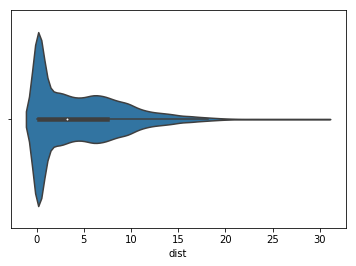

In [30]:
sns.violinplot(x=od_matrix.toPandas()["dist"])

In [31]:
inference_ok = 100*(od_matrix.filter('dist <= 1.0').count()/float(od_matrix.count()))
print "Percentage of trips with destionation satisfying threshold: ", inference_ok, "%"

Percentage of trips with destionation satisfying threshold:  34.5848726981 %


In [ ]:
print od_matrix.filter('dist <= 1.0').count()

In [ ]:
od_matrix.write.csv(path=exp_data_folder_path+'/od_matrix',header=True, mode='overwrite')

### Enriching BUSTE output with bus crowdedness information

In [85]:
trips_origins = od_matrix.filter(od_matrix.cardNum.isNotNull()) \
                            .select(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id','o_timestamp']) \
                            .groupBy(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id']) \
                            .count() \
                            .withColumnRenamed('count','boarding_cnt') \
                            .orderBy(['o_date','o_route','o_bus_code','o_tripNum'])

In [86]:
printdf(trips_origins, l=20)

,o_date,o_route,o_bus_code,o_tripNum,o_stop_id,boarding_cnt
0,2017-05-10,1,BN997,4,35219,1
1,2017-05-10,1,BN997,7,31453,1
2,2017-05-10,1,BN997,13,26166,1
3,2017-05-10,1,BN997,14,31453,1
4,2017-05-10,1,BN997,19,31453,1
5,2017-05-10,1,BN998,5,35216,1
6,2017-05-10,1,BN998,6,31453,1
7,2017-05-10,1,BN998,13,31453,1
8,2017-05-10,1,BN998,15,26375,1
9,2017-05-10,1,BN998,16,31454,1


In [87]:
trips_destinations = od_matrix.filter(od_matrix.cardNum.isNotNull()) \
                            .select(['date','route','busCode','tripNum','busStopId','timestamp']) \
                            .groupBy(['date','route','busCode','tripNum','busStopId']) \
                            .count() \
                            .orderBy(['date','route','busCode','tripNum'])

In [88]:
trips_destinations = rename_columns(
                        trips_destinations,
                        [('date','d_date'),
                         ('route','d_route'),
                         ('busCode','d_bus_code'),
                         ('tripNum','d_tripNum'),
                         ('busStopId','d_stop_id'),
                         ('count','alighting_cnt')])

In [89]:
printdf(trips_destinations, l=20)

,d_date,d_route,d_bus_code,d_tripNum,d_stop_id,alighting_cnt
0,2017-05-10,1,BN997,4,29420,1
1,2017-05-10,1,BN997,7,35219,1
2,2017-05-10,1,BN997,13,35219,1
3,2017-05-10,1,BN997,14,35216,1
4,2017-05-10,1,BN997,19,35216,1
5,2017-05-10,1,BN998,5,26375,1
6,2017-05-10,1,BN998,6,31454,1
7,2017-05-10,1,BN998,13,29082,1
8,2017-05-10,1,BN998,15,26166,1
9,2017-05-10,1,BN998,16,26166,1


In [101]:
join_columns = ['date','route','busCode','tripNum','busStopId']
origin_cond = [bus_trip_data.date == trips_origins.o_date,
               bus_trip_data.route == trips_origins.o_route, 
               bus_trip_data.busCode == trips_origins.o_bus_code, 
               bus_trip_data.tripNum == trips_origins.o_tripNum,
               bus_trip_data.busStopId == trips_origins.o_stop_id
]

dest_cond = [bus_trip_data.date == trips_destinations.d_date,
               bus_trip_data.route == trips_destinations.d_route, 
               bus_trip_data.busCode == trips_destinations.d_bus_code, 
               bus_trip_data.tripNum == trips_destinations.d_tripNum,
               bus_trip_data.busStopId == trips_destinations.d_stop_id
]


buste_crowdedness = bus_trip_data.join(trips_origins,origin_cond,'left_outer') \
                        .join(trips_destinations,dest_cond,'left_outer') \
                        .drop('o_date','o_route','o_bus_code','o_tripNum','o_stop_id') \
                        .drop('d_date','d_route','d_bus_code','d_tripNum','d_stop_id') \
                        .withColumn('boarding_cnt',F.when(F.col('boarding_cnt').isNull(),F.lit(0)).otherwise(F.col('boarding_cnt'))) \
                        .withColumn('alighting_cnt',F.when(F.col('alighting_cnt').isNull(),F.lit(0)).otherwise(F.col('alighting_cnt'))) \

In [103]:
printdf(buste_crowdedness.filter(buste_crowdedness.boarding_cnt > 0))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,timestamp,busStopId,problem,numPassengers,date,gps_timestamp,gps_timestamp_in_secs,id,boarding_cnt,alighting_cnt
0,2,5,3077,4843434,-25.424278,-49.274140,642.819,DN029,None,-25.424298,...,09:08:26,26550,NO_PROBLEM,3,2017-05-10,2017-05-10 09:08:26,1494418106,1539,2,0
1,20,3,3258,6009952,-25.494636,-49.285328,32492.225,JB601,None,-25.494625,...,11:50:46,30235,NO_PROBLEM,2,2017-05-10,2017-05-10 11:50:46,1494427846,25769805544,1,0
2,20,5,3260,6012237,-25.467617,-49.299752,16031.939,KB605,None,-25.467580,...,15:17:09,32921,NO_PROBLEM,2,2017-05-10,2017-05-10 15:17:09,1494440229,25769806420,1,0
3,21,2,3263,5215366,-25.387738,-49.282941,5468.555,CB697,None,-25.387773,...,07:30:34,27731,NO_PROBLEM,2,2017-05-10,2017-05-10 07:30:34,1494412234,34359740057,1,0
4,21,1,3269,5234135,-25.425959,-49.299201,26183.120,DR102,None,-25.425930,...,06:36:40,33065,NO_PROBLEM,3,2017-05-10,2017-05-10 06:36:40,1494409000,42949673694,2,1
5,21,2,3269,5233975,-25.390506,-49.283513,21171.467,GB600,None,-25.390591,...,08:56:00,27949,NO_PROBLEM,1,2017-05-10,2017-05-10 08:56:00,1494417360,42949675386,1,0
6,30,1,1716,6293477,-25.450790,-49.208483,11441.941,GR121,None,-25.450801,...,07:23:07,32544,NO_PROBLEM,4,2017-05-10,2017-05-10 07:23:07,1494411787,85899346403,1,0
7,40,1,1718,3368640,-25.465531,-49.345006,11563.491,BB615,None,-25.465155,...,06:51:17,35571,NO_PROBLEM,4,2017-05-10,2017-05-10 06:51:17,1494409877,94489281592,3,0
8,40,5,1718,3368493,-25.491157,-49.322237,6968.170,JB606,None,-25.491401,...,18:28:35,32656,NO_PROBLEM,1,2017-05-10,2017-05-10 18:28:35,1494451715,111669151002,1,0
9,50,5,1719,5305715,-25.450900,-49.219871,15303.345,DR114,None,-25.450961,...,14:33:00,32415,NO_PROBLEM,1,2017-05-10,2017-05-10 14:33:00,1494437580,128849019253,1,0


In [114]:
trips_window = Window.partitionBy(['date','route','busCode','tripNum']).orderBy('timestamp')

buste_crowdedness = buste_crowdedness.withColumn('crowd_bal', F.col('boarding_cnt') - F.col('alighting_cnt')) \
                        .withColumn('num_pass',F.sum('crowd_bal').over(trips_window)) \
                        .drop('numPassengers','gps_timestamp','gps_timestamp_in_secs') \
                        .orderBy(['date','route','busCode','tripNum','timestamp'])                        

In [115]:
printdf(buste_crowdedness.select(['date','route','busCode','tripNum','busStopId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp'])
       ,l=100)

,date,route,busCode,tripNum,busStopId,timestamp,boarding_cnt,alighting_cnt,crowd_bal,num_pass
0,2017-05-10,NaN,DC852,1,14404,07:39:06,0,0,0,0
1,2017-05-10,NaN,DC852,1,32415,07:40:11,0,0,0,0
2,2017-05-10,NaN,DC852,1,32413,07:40:58,0,0,0,0
3,2017-05-10,NaN,DC852,1,32412,07:41:54,0,0,0,0
4,2017-05-10,NaN,DC852,1,33024,07:42:55,0,0,0,0
5,2017-05-10,NaN,DC852,1,27959,07:46:37,0,0,0,0
6,2017-05-10,1.0,BN997,1,29887,06:21:08,0,0,0,0
7,2017-05-10,1.0,BN997,1,31453,06:22:10,0,0,0,0
8,2017-05-10,1.0,BN997,1,31454,06:22:44,0,0,0,0
9,2017-05-10,1.0,BN997,1,30748,06:24:42,0,0,0,0


In [116]:
buste_crowdedness.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- busStopId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- date: string (nullable = true)
 |-- id: long (nullable = false)
 |-- boarding_cnt: long (nullable = true)
 |-- alighting_cnt: long (nullable = true)
 |-- crowd_bal: long (nullable = true)
 |-- num_pass: long (nullable = true)



In [ ]:
buste_crowdedness.write.csv(path=exp_data_folder_path+'/buste_crowdedness',header=True, mode='overwrite')